In [21]:
import os
import torch
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import numpy as np
import itertools
import copy
import os
import random
from shutil import copyfile


In [22]:

# Set environment variable
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Train and test data directory 
data_dir = r"C:\Users\kavya\Documents\UMN\Covid19\Data\Train"
test_data_dir = r'C:\Users\kavya\Documents\UMN\Covid19\Data\Test'
classes = ('covid', 'normal')
def balance_dataset(base_dir, classes):
    # Iterate over the classes to balance each one
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        images = os.listdir(class_dir)

        # Get the count of images for the other class
        other_class = classes[1] if cls == classes[0] else classes[0]
        other_class_dir = os.path.join(base_dir, other_class)
        other_images = os.listdir(other_class_dir)

        # Find the minimum number of images between the two classes
        min_images = min(len(images), len(other_images))

        # If current class has more images, undersample
        if len(images) > min_images:
            images_to_remove = random.sample(images, len(images) - min_images)
            for img in images_to_remove:
                os.remove(os.path.join(class_dir, img))

        # If current class has fewer images, oversample
        elif len(images) < min_images:
            images_to_add = random.choices(images, k=min_images - len(images))
            for img in images_to_add:
                original_path = os.path.join(class_dir, img)
                new_image_name = f"copy_{img}"
                new_path = os.path.join(class_dir, new_image_name)
                copyfile(original_path, new_path)

# Balance the training and test datasets
balance_dataset(data_dir, classes)
balance_dataset(test_data_dir, classes)

print("Datasets balanced successfully.")

Datasets balanced successfully.


In [23]:

# Load the train and test data
data_transforms_train = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_transforms_val_test = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageFolder(data_dir, transform=data_transforms_train)
val_test_dataset = ImageFolder(test_data_dir, transform=data_transforms_val_test)


In [24]:

# Split data into training and validation
batch_size = 32
val_size = 50
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2, shuffle=False)
test_loader = DataLoader(val_test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)


In [25]:

# Display a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


In [26]:

# Function to save the model
def save_model(model, path="./resnet18.pth"):
    torch.save(model.state_dict(), path)


In [27]:

# Function to evaluate the model
def evaluate(loader, model, device):
    model.eval()
    accuracy, total = 0.0, 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    accuracy = (100 * accuracy / total)
    cm = confusion_matrix(y_true, y_pred)
    # plot_confusion_matrix(cm, target_names=classes, normalize=False)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    return accuracy, precision, recall, f1


In [28]:

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        save_model(model)
        self.val_loss_min = val_loss


In [29]:

# Training function with early stopping
def train(model, device, train_loader, val_loader, optimizer, loss_fn, num_epochs=20):
    best_accuracy = 0.0
    model.to(device)
    early_stopping = EarlyStopping(patience=1, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
        val_accuracy, _, _, _ = evaluate(val_loader, model, device)

        early_stopping(avg_train_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break


In [30]:

# Plot confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.4f}" if normalize else f"{cm[i, j]:,}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.show()


In [31]:

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    # Load pretrained resnet model
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer for our specific classification task
    model.fc = nn.Linear(model.fc.in_features, len(classes))

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # Train the model
    # train_status = True
    train(model, device, train_loader, val_loader, optimizer, loss_fn)
    print('Finished Training')
    train_status = True
    if train_status:
        model.load_state_dict(torch.load("resnet18.pth"))
        model.to(device)
        evaluate(test_loader, model, device)


The model will be running on cpu device


KeyboardInterrupt: 

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from shutil import copyfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchviz import make_dot
import torchviz
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score,auc

In [33]:
from torchvision import models
import torch.nn as nn

# Initialize a pre-trained resnet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the fully connected layer for binary classification (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming it's for binary classification

# Load the saved state_dict
model_path = r'C:\Users\kavya\Documents\UMN\Covid19\Code\resnet18.pth'
checkpoint = torch.load(model_path)

# Load state_dict into the modified model
model.load_state_dict(checkpoint, strict=False)  # Using strict=False allows some flexibility if the keys differ slightly
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully.")


Model loaded successfully.


C:\Users\kavya\AppData\Local\Temp\ipykernel_2004\3507150531.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


C:\Users\kavya\AppData\Local\Temp\ipykernel_2004\3564050750.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


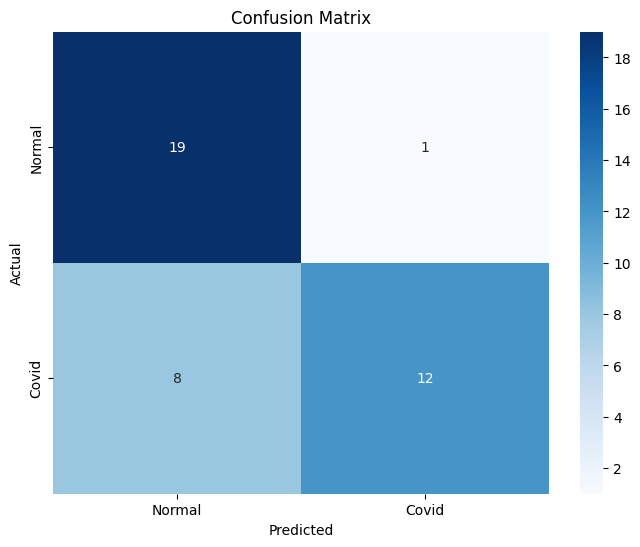

In [34]:
# Load the model weights
model_path = r'C:\Users\kavya\Documents\UMN\Covid19\Code\resnet18.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint, strict=False)
model.eval()

# Define transform for the test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load test data
test_data_path = r'C:\Users\kavya\Documents\UMN\Covid19\Data\Test'
test_data = datasets.ImageFolder(root=test_data_path, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Prepare for evaluation
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probabilities = nn.Softmax(dim=1)(outputs)  # Get class probabilities

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
        all_probs.extend(probabilities[:, 1].numpy())  # Probability for positive class

# Convert lists to numpy arrays for compatibility with scikit-learn
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

### Confusion Matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Covid'], yticklabels=['Normal', 'Covid'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




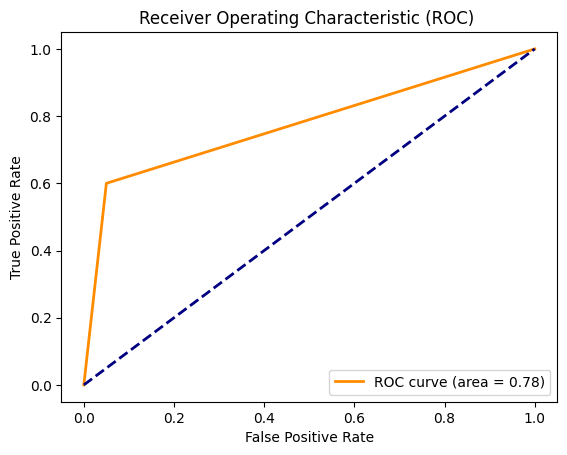

In [35]:
fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) ')
plt.legend(loc='lower right')
plt.show()

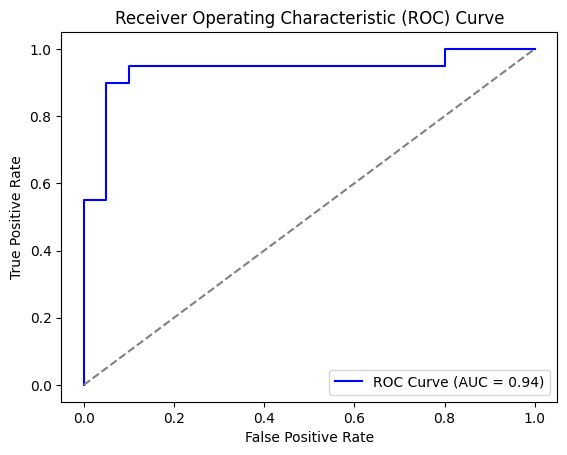

AUC Score: 0.94


In [36]:
### ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC Score
print(f'AUC Score: {roc_auc:.2f}')


In [37]:

# Calculate performance metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



Accuracy: 0.78
Precision: 0.81
Recall: 0.78
F1 Score: 0.77
